## Harry Potter (BookNo1. - Harry Potter and the Sorcerer's Stone)

Link to datasets (preuzeta samo prva knjiga): https://github.com/ErikaJacobs/Harry-Potter-Text-Mining/tree/master/Book%20Text

Dole sam isprobala **LDA** i **BERTopic**, sa različito podešenim parametrima. Rezultati su vrlo jednolični (u smislu, izoluje se malo tema), ali to ustvari uopšte nije čudno jer literatura koja se bavi književnom (teorijskom) analizom ovog dela takođe govori o tome da je sadržaj jednoličan, u smislu da se stalno vrte iste teme, isti pridevi, iste priče, sve isto i da je teško napraviti distinkciju u tematici (što se slaže i sa ovim našim rezultatima).

In [1]:
# Opšti paketi
import re
import itertools
import numpy as np
import pandas as pd
import spacy
import string

# NLP alati
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Gensim - za LDA
import gensim
from gensim import corpora, models
import itertools
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from pprint import pprint
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from gensim.models import LdaModel

# BERTopic
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Dimenzionalna redukcija (koristi je BERTopic)
import umap

# Vizualizacija (ako budeš htela kasnije)
import matplotlib.pyplot as plt

# Sklearn - ako bude potrebno za vektore ili dodatnu analizu
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Preuzimanje NLTK resursa (prvi put)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Izbaci warnings
import warnings
warnings.filterwarnings("ignore")

/Users/isidoragataric/miniconda3/envs/isi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isidoragataric/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Učitavanje teksta iz fajla (uzimam samo prvu knjigu)
with open("HPBook1.txt", "r", encoding="utf-8") as f:
    text = f.read()

# ✔️ Provera prvih 500 karaktera
print(text[:500])

"Text"@"Chapter"@"Book"
"THE BOY WHO LIVED  Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.  Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Mrs. Dursley was thin and 


# Pre-processing teksta

In [3]:
# Definišem stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [4]:
# Čišćenje teksta od svega i svačega
def clean_text(text):
    # 1. Uklanjanje ličnih imena iz originalnog teksta putem spaCy NER
    doc_ner = nlp(text)
    ents_to_remove = [ent for ent in doc_ner.ents if ent.label_ == 'PERSON']
    
    intervals = [(ent.start_char, ent.end_char) for ent in ents_to_remove]
    intervals = sorted(intervals, reverse=True)
    
    for start, end in intervals:
        text = text[:start] + ' ' + text[end:]

    # 2. Standardno čišćenje
    text = text.lower()
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    lines = text.split('\n')
    lines = [line for line in lines if not line.startswith('"Text"@')]
    text = ' '.join(lines)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Ručno definisane reči koje želiš da izbaciš
    custom_remove_words = {
        'hagrid', 'snape', 'hermione', 'neville',  # imena
        'could', 'would', 'i', 'me', 'you', 'we', 'us', 'my', 'your', 'ronan', 'petunia', 'vernon', 'say', 'get', 'mrs', 'mr' # jednostavne reči
    }

    # 4. Tokenizacija i uklanjanje i stopwords i custom reči
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and word not in custom_remove_words]

    # 5. Lemmatizacija i finalno filtriranje
    doc = nlp(' '.join(tokens))
    lemmas = [token.lemma_ for token in doc
              if token.lemma_ not in stop_words and token.lemma_ not in custom_remove_words and token.lemma_.isalpha()]

    cleaned_text = ' '.join(lemmas)
    return cleaned_text, lemmas

#results = [clean_text(doc) for doc in documents]
texts, tokens_list = clean_text(text)
#texts, tokens_list = zip(*results) 

# LDA

In [5]:
# Celokupna knjiga se deli na segmente
def split_text(text, max_words=100):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = " ".join(words[i:i+max_words])
        chunks.append(chunk)
    return chunks

# 1. Očisti ceo tekst i izdvoji lemme
cleaned_text, all_lemmas = clean_text(text)

# 2. Napravi očišćen tekst spojen u string
cleaned_text_str = ' '.join(all_lemmas)

# 3. Podeli na chunkove od max 100 reči
chunks = split_text(cleaned_text_str, max_words=100)

# 4. Tokenizuj svaki chunk (za LDA dictionary i corpus)
tokens_list = [chunk.split() for chunk in chunks]

# 5. Kreiraj dictionary i corpus za gensim LDA
dictionary = corpora.Dictionary(tokens_list)
corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]

print(f"📄 Broj segmenata za LDA: {len(tokens_list)}")

📄 Broj segmenata za LDA: 346


In [6]:
######### LDA BIGRAMI

# --------------------------------------------
# 1. Kreiranje bigrama iz tokena — opušteniji parametri!
bigram = Phrases(tokens_list, min_count=2, threshold=1)
bigram_mod = Phraser(bigram)

# Pretvaramo originalne tokene u bigramsku verziju
tokens_bigrams = [bigram_mod[doc] for doc in tokens_list]

# Opcionalno: proveri da li su bigrami ubačeni
print("\n✅ Provera bigrama na prvom dokumentu:")
print("Pre:", tokens_list[0])
print("Posle:", tokens_bigrams[0])

# --------------------------------------------
# 2. Dictionary i corpus na osnovu bigrama
dictionary = corpora.Dictionary(tokens_bigrams)
corpus = [dictionary.doc2bow(tokens) for tokens in tokens_bigrams]

# Opcionalno: prikaži nekoliko reči iz dictionary-ja
print("\n📘 Primeri reči iz dictionary-ja:")
for i in range(min(30, len(dictionary))):
    print(f"{i}: {dictionary[i]}")

# --------------------------------------------
# 3. LDA kombinacije parametara
num_topics_list = [5, 8, 10]
alpha_list = ['symmetric', 'asymmetric']
passes_list = [10, 20]

lda_results = []

print("\n📊 LDA MODELI\n")

for num_topics, alpha, passes in itertools.product(num_topics_list, alpha_list, passes_list):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        passes=passes,
        random_state=42
    )

    # Coherence Score
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=tokens_bigrams,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()

    # Perplexity
    perplexity = lda_model.log_perplexity(corpus)

    print(f"\n--- LDA --- Topics: {num_topics} | Alpha: {alpha} | Passes: {passes}")
    pprint(lda_model.print_topics(num_words=5))
    print(f"Perplexity: {perplexity:.2f} | Coherence: {coherence:.4f}")

    lda_results.append({
        "num_topics": num_topics,
        "alpha": alpha,
        "passes": passes,
        "model": lda_model,
        "perplexity": perplexity,
        "coherence": coherence
    })

# --------------------------------------------
# 4. Pronalaženje najboljeg modela po coherence-u
best_model = max(lda_results, key=lambda x: x["coherence"])

print("\n🏆 NAJBOLJI MODEL:")
print(f"Topics: {best_model['num_topics']} | Alpha: {best_model['alpha']} | Passes: {best_model['passes']}")
print(f"Coherence Score: {best_model['coherence']:.4f}")
pprint(best_model['model'].print_topics(num_words=10))


✅ Provera bigrama na prvom dokumentu:
Pre: ['text', 'chapter', 'book', 'boy', 'live', 'number', 'four', 'proud', 'perfectly', 'normal', 'thank', 'much', 'last', 'people', 'expect', 'involve', 'anything', 'strange', 'mysterious', 'hold', 'nonsense', 'director', 'firm', 'call', 'grunning', 'make', 'drill', 'big', 'beefy', 'man', 'hardly', 'neck', 'although', 'large', 'mustache', 'thin', 'blonde', 'nearly', 'twice', 'usual', 'amount', 'neck', 'come', 'useful', 'spend', 'much', 'time', 'crane', 'garden', 'fence', 'spy', 'neighbor', 'small', 'son', 'call', 'opinion', 'fine', 'boy', 'anywhere', 'everything', 'want', 'also', 'secret', 'great', 'fear', 'somebody', 'discover', 'think', 'bear', 'anyone', 'find', 'potter', 'sister', 'meet', 'several', 'year', 'fact', 'pretend', 'sister', 'sister', 'good', 'nothing', 'husband', 'undursleyish', 'possible', 'shudder', 'think', 'neighbor', 'potter', 'arrive', 'street', 'know', 'small', 'son', 'never', 'even', 'see', 'boy', 'another', 'good']
Posle: 

In [7]:
# Testiram koji model je najbolji prema coherence score-u
for result in lda_results:
    model = result["model"]
    coherence_model = CoherenceModel(
        model=model, 
        texts=tokens_bigrams,  # <- koristi bigrame
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    result["coherence"] = coherence
    print(f"LDA | Topics: {result['num_topics']} | Alpha: {result['alpha']} | Passes: {result['passes']} | Perplexity: {result['perplexity']:.2f} | Coherence: {coherence:.4f}")

LDA | Topics: 5 | Alpha: symmetric | Passes: 10 | Perplexity: -8.01 | Coherence: 0.2239
LDA | Topics: 5 | Alpha: symmetric | Passes: 20 | Perplexity: -8.01 | Coherence: 0.2343
LDA | Topics: 5 | Alpha: asymmetric | Passes: 10 | Perplexity: -8.00 | Coherence: 0.2337
LDA | Topics: 5 | Alpha: asymmetric | Passes: 20 | Perplexity: -8.00 | Coherence: 0.2301
LDA | Topics: 8 | Alpha: symmetric | Passes: 10 | Perplexity: -8.12 | Coherence: 0.2212
LDA | Topics: 8 | Alpha: symmetric | Passes: 20 | Perplexity: -8.11 | Coherence: 0.2192
LDA | Topics: 8 | Alpha: asymmetric | Passes: 10 | Perplexity: -8.10 | Coherence: 0.2301
LDA | Topics: 8 | Alpha: asymmetric | Passes: 20 | Perplexity: -8.09 | Coherence: 0.2324
LDA | Topics: 10 | Alpha: symmetric | Passes: 10 | Perplexity: -8.17 | Coherence: 0.2253
LDA | Topics: 10 | Alpha: symmetric | Passes: 20 | Perplexity: -8.16 | Coherence: 0.2273
LDA | Topics: 10 | Alpha: asymmetric | Passes: 10 | Perplexity: -8.16 | Coherence: 0.2145
LDA | Topics: 10 | Alpha

In [8]:
# Automatsko pronalaženje najboljeg LDA modela po coherence score-u (računato na bigramima)
best_model = max(lda_results, key=lambda x: x["coherence"])

print("\n🏆 Najbolji LDA model po koherentnosti:")
print(f"Topics: {best_model['num_topics']}, Alpha: {best_model['alpha']}, Passes: {best_model['passes']}, Coherence: {best_model['coherence']:.4f}")

# Možeš koristiti ovaj model dalje (npr. za predikciju, vizualizaciju itd.)
lda_best = best_model["model"]


🏆 Najbolji LDA model po koherentnosti:
Topics: 5, Alpha: symmetric, Passes: 20, Coherence: 0.2343


In [9]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # ako koristiš gensim >= 4

# Korpus i dictionary su već bigramski, kao i model
lda_best = best_model["model"]

# Priprema za vizualizaciju
vis_data = gensimvis.prepare(lda_best, corpus, dictionary)

# Ako si u Jupyter okruženju:
pyLDAvis.display(vis_data)

# Ako nisi u Jupyteru, koristi:
# pyLDAvis.save_html(vis_data, 'lda_bigrams_visualization.html')
pyLDAvis.display(vis_data)

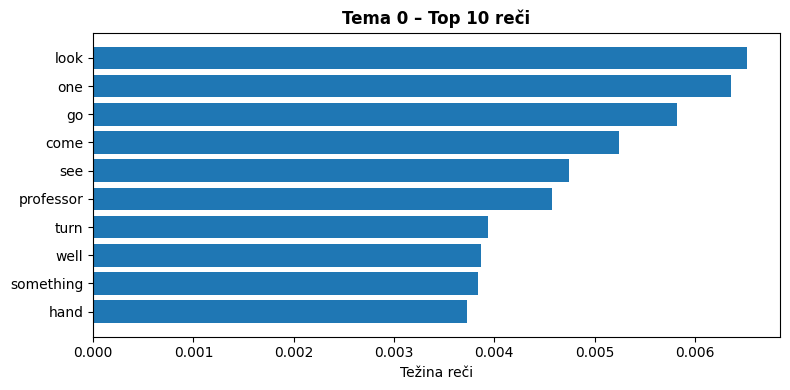

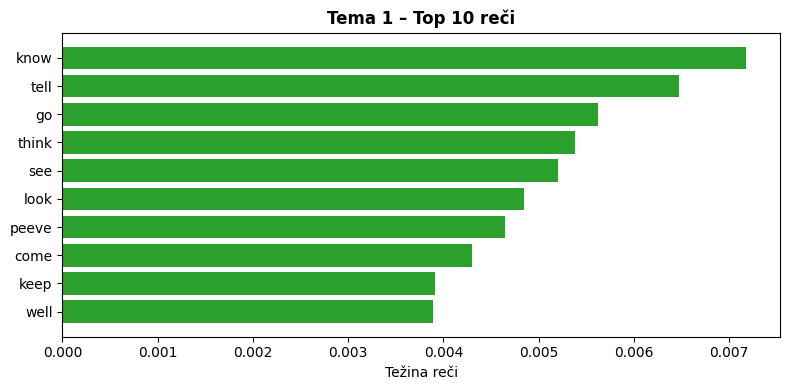

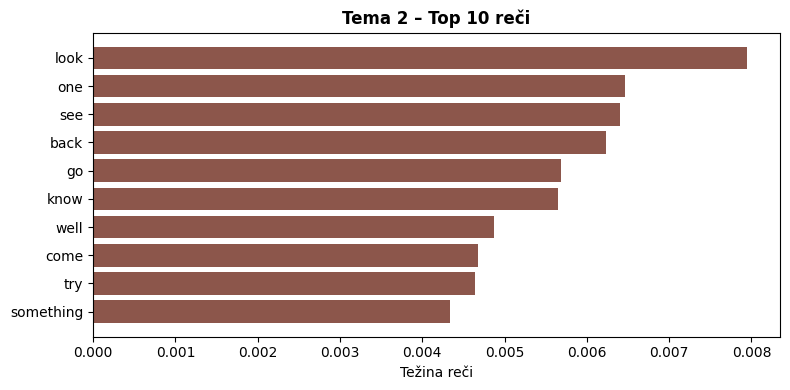

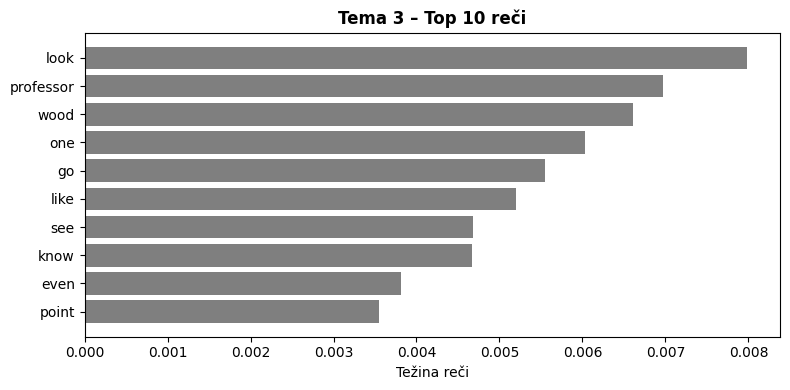

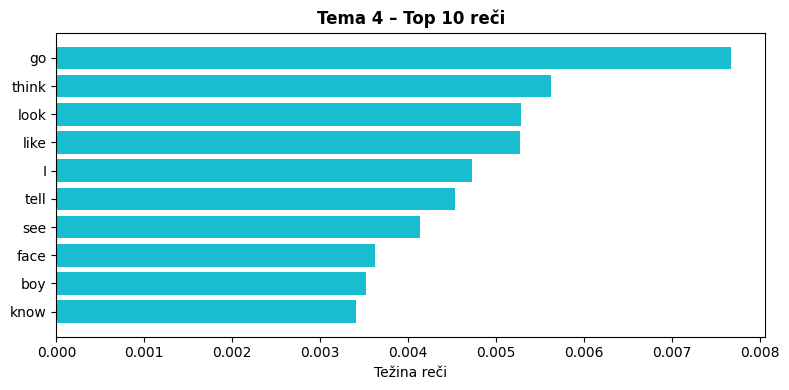

In [10]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
import numpy as np

# 📌 LDA model (iz best_model)
lda_best = best_model["model"]

# ---------------------------
# 📊 1. Interaktivna pyLDAvis vizualizacija
vis_data = gensimvis.prepare(lda_best, corpus, dictionary)
pyLDAvis.display(vis_data)

# ---------------------------
# 📈 2. Bar chart top reči po svakoj temi
def plot_top_words_per_topic(lda_model, num_words=10, cmap="Set2"):
    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
    colors = plt.cm.get_cmap(cmap, len(topics))  # paleta boja po broju tema
    
    for i, (topic_num, topic_words) in enumerate(topics):
        words = [w for w, _ in topic_words]
        weights = [p for _, p in topic_words]
        
        plt.figure(figsize=(8, 4))
        plt.barh(words[::-1], weights[::-1], color=colors(i))  # dodela boje
        plt.title(f"Tema {topic_num} – Top {num_words} reči", fontsize=12, fontweight="bold")
        plt.xlabel("Težina reči")
        plt.tight_layout()
        plt.show()

# Prikaz bar chart-ova za svaku temu
plot_top_words_per_topic(lda_best, num_words=10, cmap="tab10")

# BERTopic

In [11]:
# 1. Podela sirovog teksta po paragrafima
paragraphs = re.split(r'\n\s*\n', text)

# 2. Čišćenje svakog paragrafa i čuvanje svih tokena (lema)
all_lemmas = []
for para in paragraphs:
    _, lemmas = clean_text(para)
    if lemmas:
        all_lemmas.extend(lemmas)

# 3. Pretvaramo sve leme nazad u string (celokupan očišćen tekst)
cleaned_text = ' '.join(all_lemmas)

# 4. Delimo očišćen tekst na chunkove po 100 reči
def split_text(text, max_words=100):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = " ".join(words[i:i+max_words])
        chunks.append(chunk)
    return chunks

texts = split_text(cleaned_text, max_words=100)
print(f"📘 Broj segmenata za BERTopic: {len(texts)}")

📘 Broj segmenata za BERTopic: 346


In [12]:
# 5. Učitavanje SentenceTransformer embedding modela
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# 6. Parametri koje ćemo testirati
ngram_ranges = [(1, 1), (1, 2)]
min_topic_sizes = [5, 10]

bertopic_results = []

# 7. Loop kroz različite kombinacije parametara
for ngram_range, min_size in itertools.product(ngram_ranges, min_topic_sizes):
    print(f"\n🔍 Treniranje BERTopic | n-gram: {ngram_range}, min_topic_size: {min_size}")

    vectorizer_model = CountVectorizer(
        ngram_range=ngram_range,
        stop_words="english"
    )

    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        min_topic_size=min_size,
        verbose=False
    )

    topics, probs = topic_model.fit_transform(texts)

    info = topic_model.get_topic_info()
    print(info.head(3))

    bertopic_results.append({
        "ngram": ngram_range,
        "min_topic_size": min_size,
        "model": topic_model,
        "topics": topics,
        "topic_info": info
    })


🔍 Treniranje BERTopic | n-gram: (1, 1), min_topic_size: 5
   Topic  Count                        Name  \
0     -1     85     -1_look_like_know_think   
1      0     47     0_door_peeve_right_look   
2      1     33  1_aunt_letter_cupboard_car   

                                      Representation  \
0  [look, like, know, think, come, professor, tel...   
1  [door, peeve, right, look, come, hear, head, f...   
2  [aunt, letter, cupboard, car, want, pier, day,...   

                                 Representative_Docs  
0  [people mirror trick reflect invisible look mi...  
1  [know yeh well follow clearing stare shoulder ...  
2  [brown orange puff ball hard try pull head sma...  

🔍 Treniranje BERTopic | n-gram: (1, 1), min_topic_size: 10
   Topic  Count                          Name  \
0     -1    130  -1_look_know_think_professor   
1      0     42       0_door_peeve_right_come   
2      1     34    1_letter_aunt_cat_cupboard   

                                      Representati


🏆 Najbolji BERTopic model:
- ngram_range: (1, 1)
- min_topic_size: 5
- Broj pravih tema: 13

📄 Sve teme:
    Topic  Count                           Name  \
1       0     47        0_door_peeve_right_look   
2       1     33     1_aunt_letter_cupboard_car   
3       2     27    2_professor_cloak_look_book   
4       3     24      3_quirrell_stone_know_try   
5       4     24   4_broom_wood_bludger_quaffle   
6       5     23       5_train_platform_boy_owl   
7       6     22          6_know_boy_yeh_wizard   
8       7     21    7_slytherin_hat_table_house   
9       8     10          8_dragon_tell_ter_egg   
10      9      9  9_gryffindor_think_point_lose   
11     10      7       10_wand_inch_curious_yes   
12     11      7  11_stone_flamel_look_sorcerer   
13     12      7   12_quidditch_team_match_wood   

                                       Representation  \
1   [door, peeve, right, look, come, hear, head, f...   
2   [aunt, letter, cupboard, car, want, pier, day,...   
3   [pro

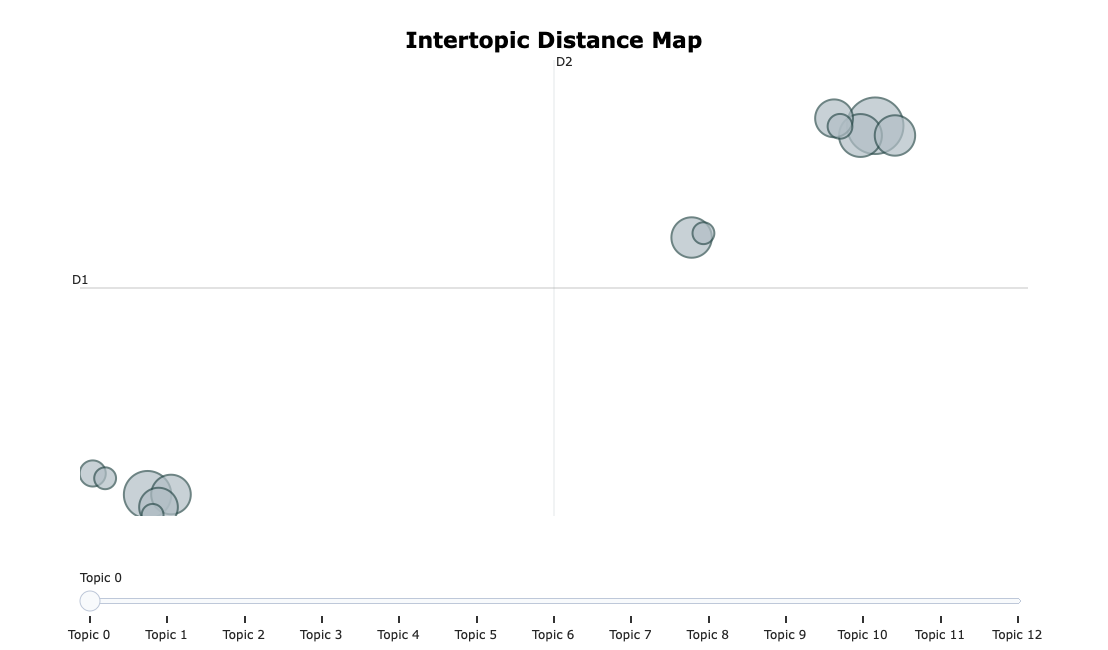

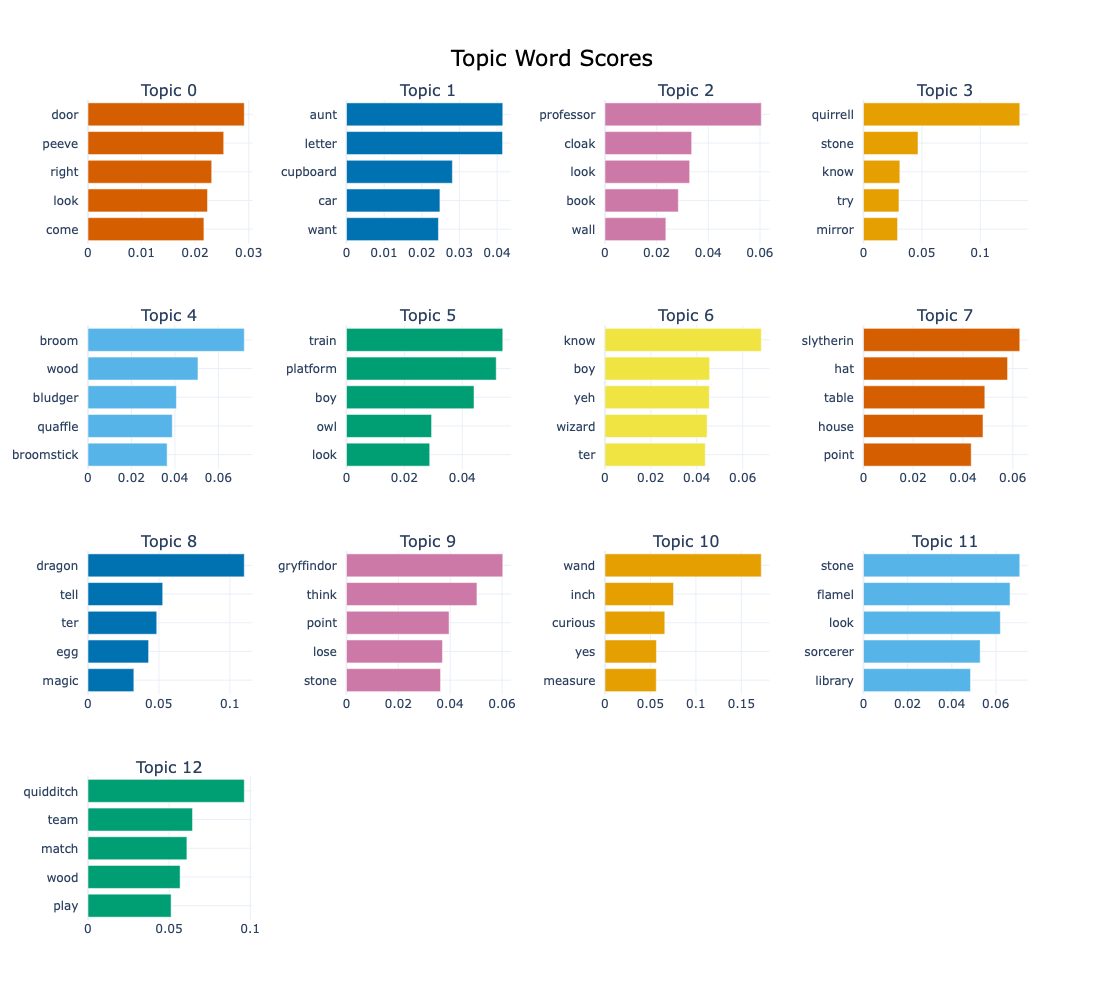

In [13]:
# 🔢 Funkcija za broj pravih tema (isključujući outlier -1)
def count_true_topics(topic_info_df):
    return topic_info_df[topic_info_df.Topic != -1].shape[0]

# 🥇 Izbor najboljeg modela po broju pravih tema
best_bertopic = max(bertopic_results, key=lambda x: count_true_topics(x["topic_info"]))
best_model = best_bertopic["model"]

print("\n🏆 Najbolji BERTopic model:")
print(f"- ngram_range: {best_bertopic['ngram']}")
print(f"- min_topic_size: {best_bertopic['min_topic_size']}")
print(f"- Broj pravih tema: {count_true_topics(best_bertopic['topic_info'])}")

# 🧾 Prikaz svih 13 tema
print("\n📄 Sve teme:")
topic_info = best_model.get_topic_info()
print(topic_info[topic_info.Topic != -1].head(13))  # samo 13 tema, bez -1 outlier-a

# 📊 Interaktivna vizualizacija svih tema
best_model.visualize_topics().show()

# 📈 Bar chart za svih 13 tema
best_model.visualize_barchart(top_n_topics=13).show()
